# Importing

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('crest')
from scipy import stats

from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.preprocessing import  RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import time

from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import make_scorer, mean_squared_log_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.isotonic import IsotonicRegression

In [150]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Playground Series S3 EP 11/Input/train.csv')

# First Look

In [151]:
df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [152]:
df = df.drop('id', axis=1)

In [153]:
df.shape

(360336, 16)

In [154]:
df.isnull().sum()

store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [155]:
df[ df.duplicated() ]

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost


In [156]:
df.dtypes

store_sales(in millions)      float64
unit_sales(in millions)       float64
total_children                float64
num_children_at_home          float64
avg_cars_at home(approx).1    float64
gross_weight                  float64
recyclable_package            float64
low_fat                       float64
units_per_case                float64
store_sqft                    float64
coffee_bar                    float64
video_store                   float64
salad_bar                     float64
prepared_food                 float64
florist                       float64
cost                          float64
dtype: object

# Understand Data

## Target

<Axes: xlabel='cost', ylabel='Count'>

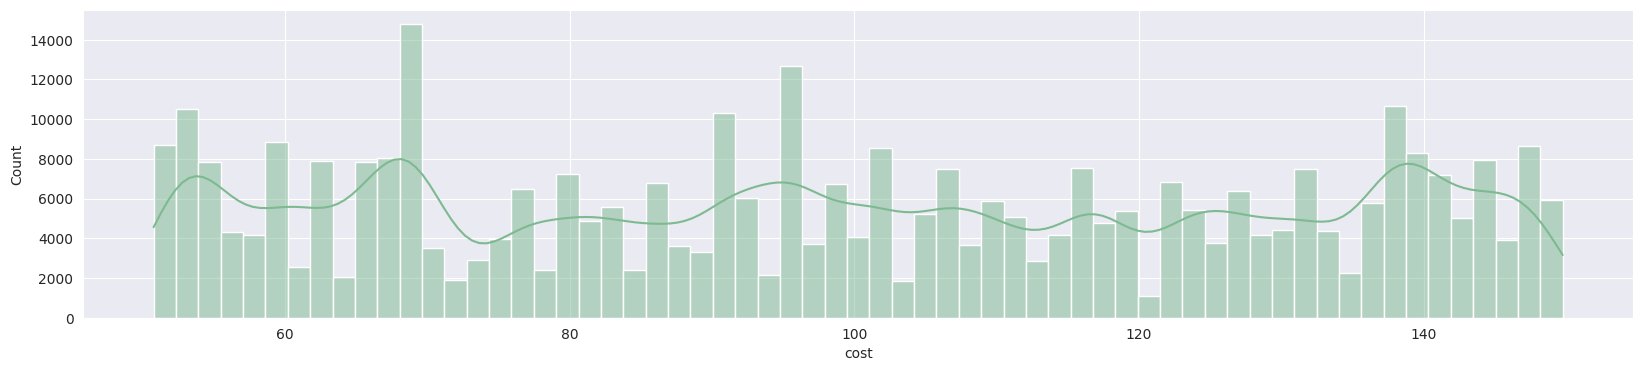

In [157]:
plt.figure(figsize=(20,4))
sns.histplot(data=df, x='cost', kde=True)

<Axes: xlabel='cost'>

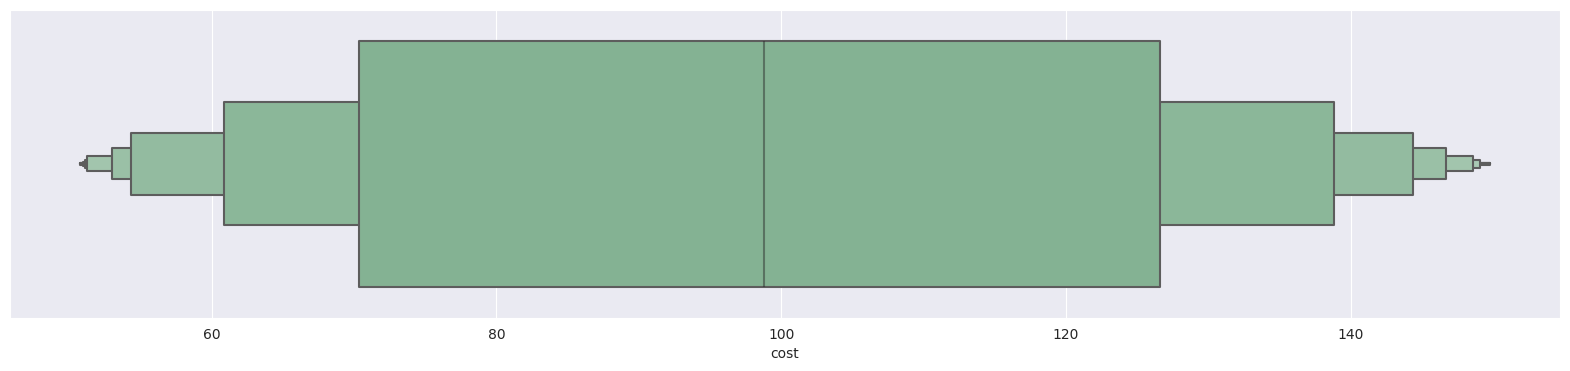

In [158]:
plt.figure(figsize=(20,4))
sns.boxenplot(data=df, x='cost')

Kolmogorov-Smirnov

In [159]:
stats.kstest(df['cost'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=50.79, statistic_sign=-1)

Shapiro-Wilk

In [160]:
stats.shapiro(df['cost'])

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9444851875305176, pvalue=0.0)

Anderson-Darling

Target has been distributed 

## Univariate

In [161]:
n_values = pd.Series(dtype='float64')
for col in df.drop('cost', axis=1).columns:
    n_values[col] = len(df[col].unique())

n_values = n_values.sort_values(ascending=False)
n_values

store_sales(in millions)      1044
gross_weight                   384
units_per_case                  36
store_sqft                      20
unit_sales(in millions)          6
total_children                   6
num_children_at_home             6
avg_cars_at home(approx).1       5
recyclable_package               2
low_fat                          2
coffee_bar                       2
video_store                      2
salad_bar                        2
prepared_food                    2
florist                          2
dtype: int64

In [162]:
num = n_values[:4].index
cat = n_values[4:].index

print('Numerical Features: ', len(num))
print('Categorical Features: ', len(cat))

Numerical Features:  4
Categorical Features:  11


### Numerical

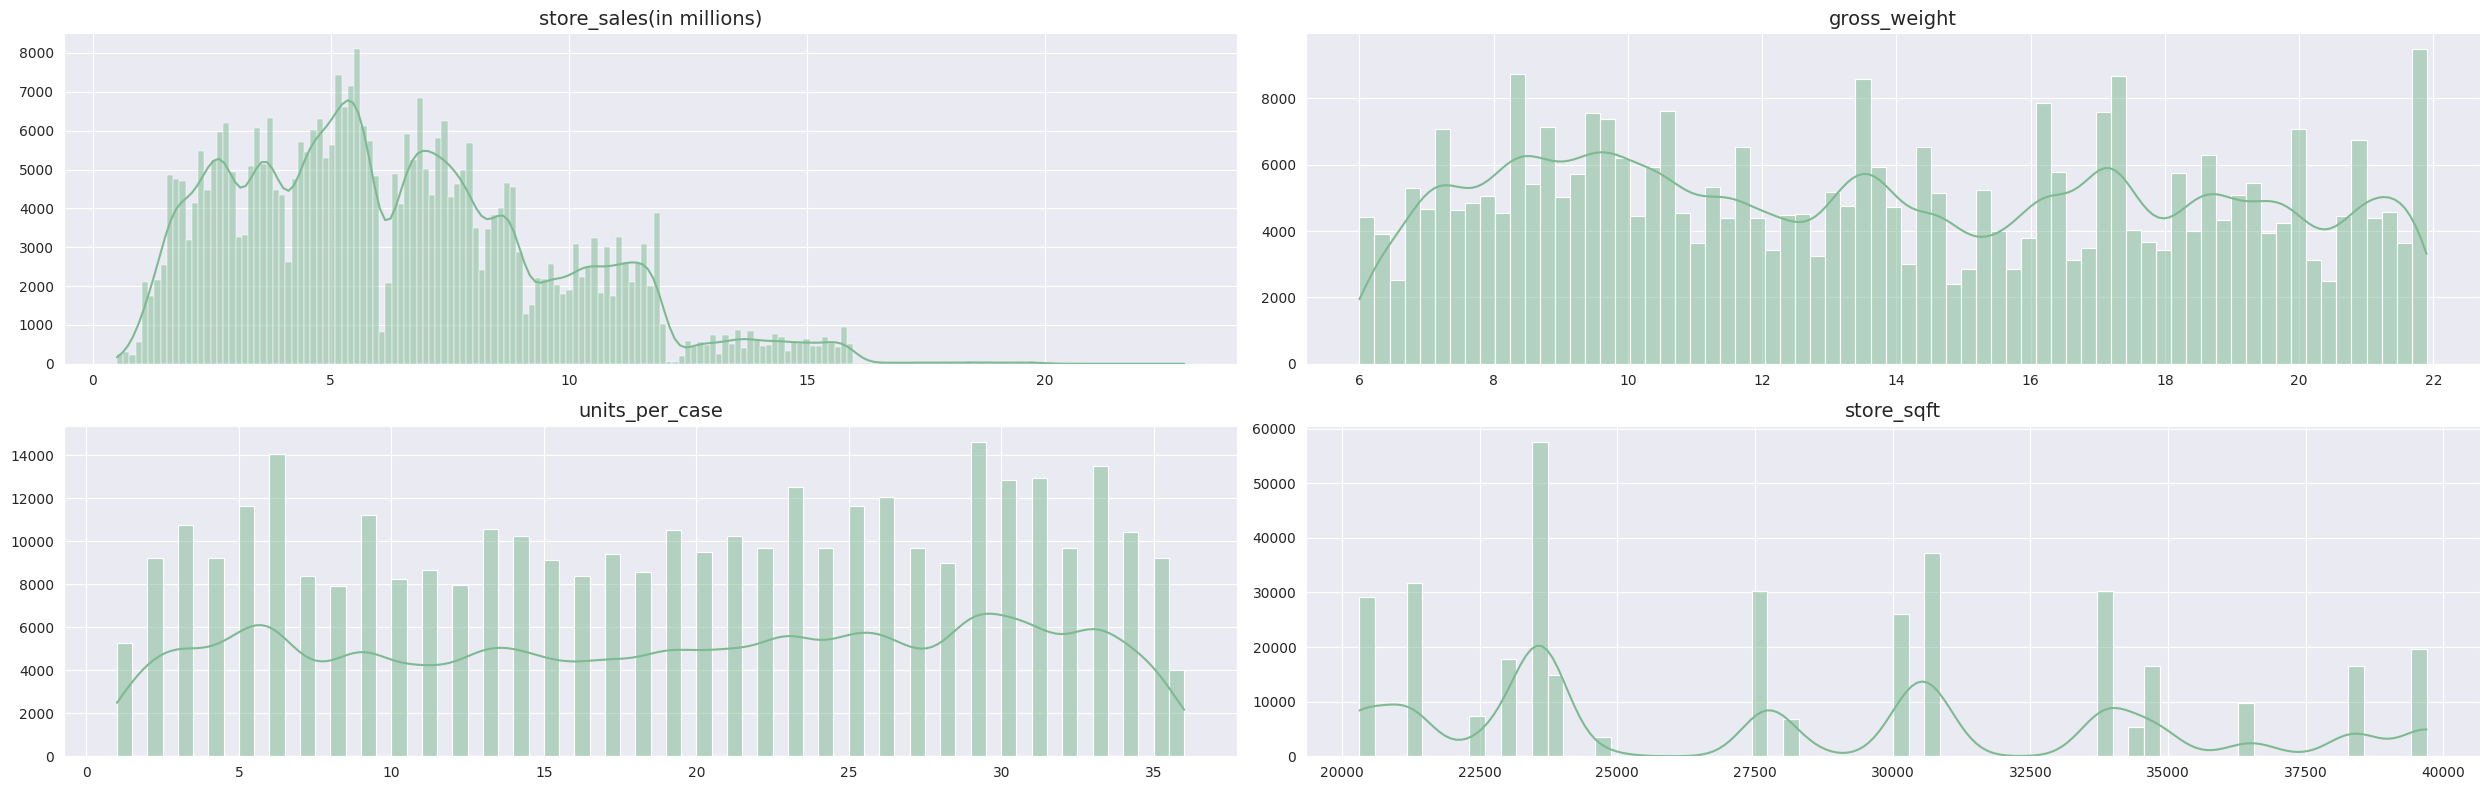

In [163]:
fig, axs = plt.subplots(2,2, figsize=(25,8))
axs = axs.ravel()

for i, col in enumerate(num):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label=col, fontsize=14)

plt.tight_layout()

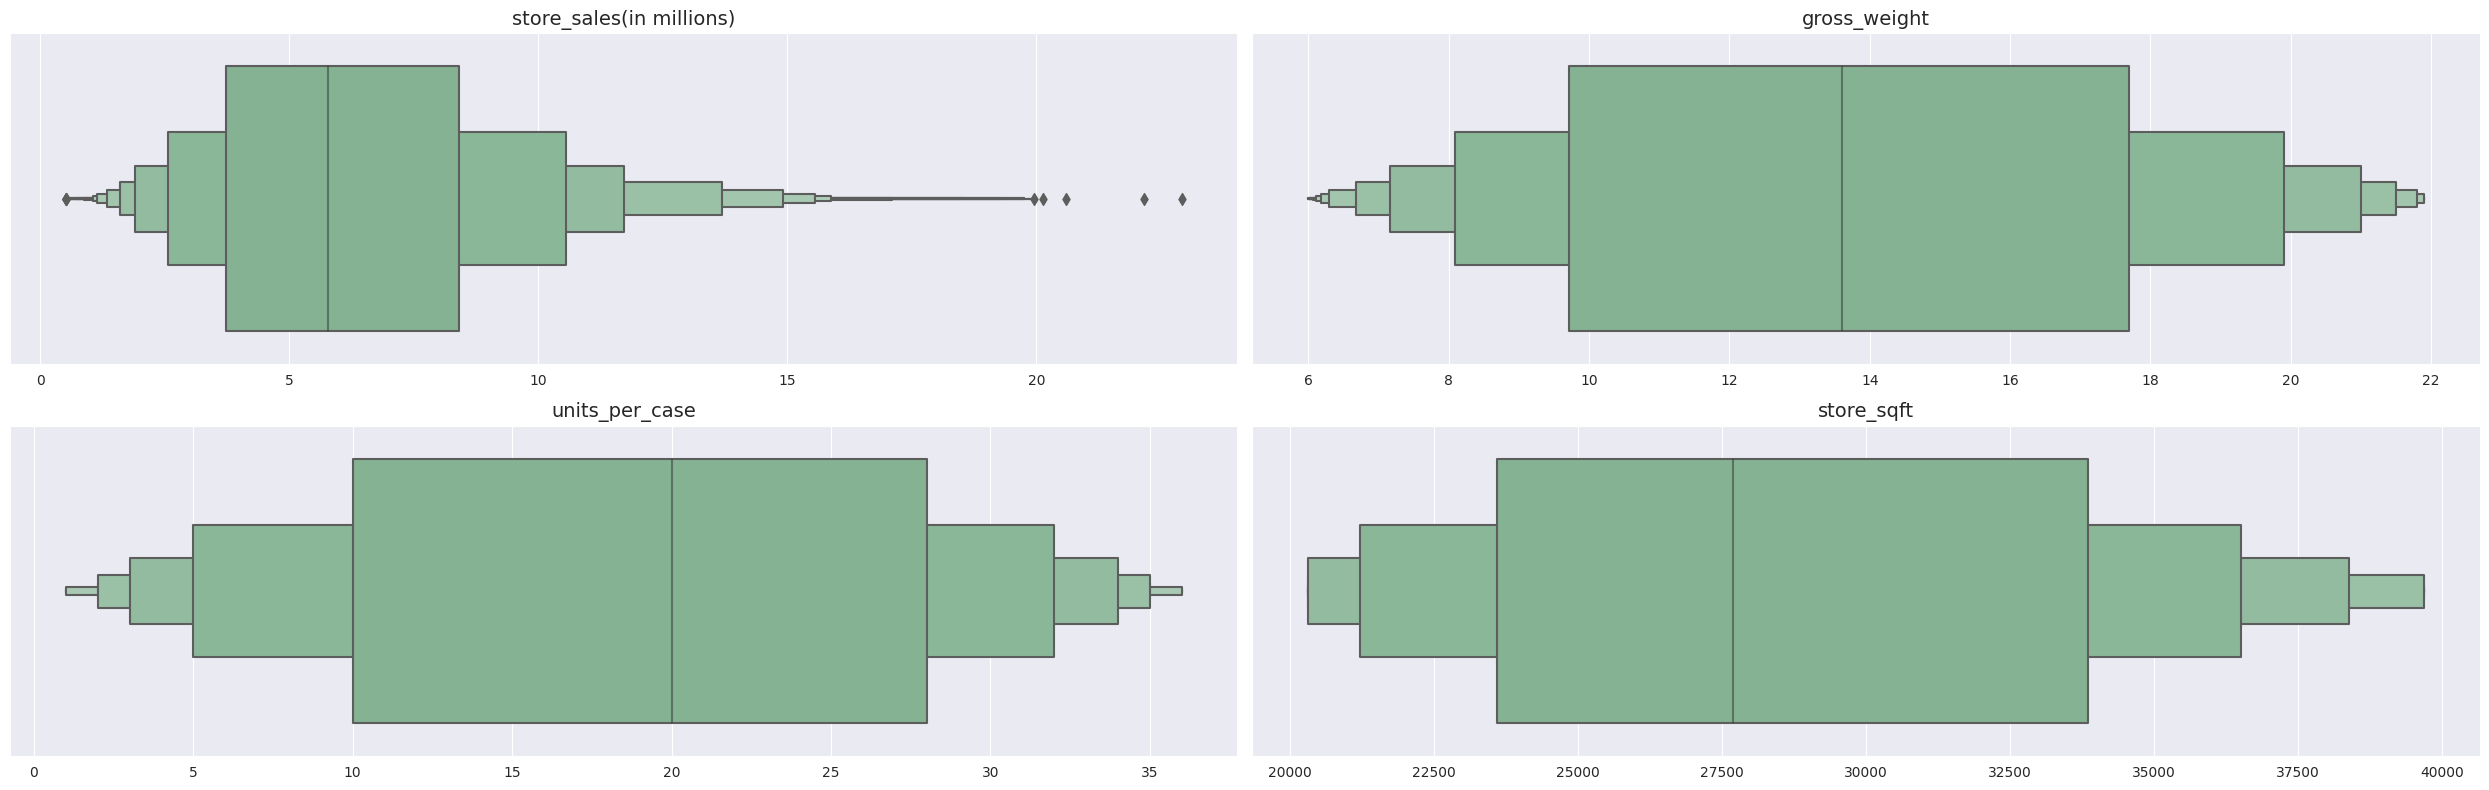

In [164]:
fig, axs = plt.subplots(2,2, figsize=(25,8))
axs = axs.ravel()

for i, col in enumerate(num):
    sns.boxenplot(data=df, x=col, ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label=col, fontsize=14)

plt.tight_layout()

In [165]:
outlier_col = 'store_sales(in millions)'

In [166]:
df['units_per_case'].value_counts()

29.0    14626
6.0     14064
33.0    13483
31.0    12947
30.0    12847
23.0    12517
26.0    12050
25.0    11651
5.0     11624
9.0     11219
3.0     10736
13.0    10577
19.0    10525
34.0    10401
21.0    10242
14.0    10234
24.0     9698
27.0     9697
22.0     9677
32.0     9668
20.0     9471
17.0     9390
35.0     9203
2.0      9195
4.0      9194
15.0     9100
28.0     8960
11.0     8648
18.0     8575
16.0     8378
7.0      8367
10.0     8217
12.0     7949
8.0      7928
1.0      5273
36.0     4005
Name: units_per_case, dtype: int64

In [167]:
df['units_per_case'] = df['units_per_case'].astype('int64')

In [168]:
df['store_sqft'].value_counts()

21215.0    31807
27694.0    30280
33858.0    30218
23598.0    29659
20319.0    29193
30268.0    25995
30797.0    24271
39696.0    19690
23112.0    17765
34791.0    16498
38382.0    16454
23688.0    16072
23759.0    14934
30584.0    13016
23593.0    11877
36509.0     9701
22478.0     7314
28206.0     6787
34452.0     5319
24597.0     3486
Name: store_sqft, dtype: int64

In [169]:
df['store_sqft'] = df['store_sqft'].astype('int64')

All numerical features have been distributed

### Categorical

In [170]:
df[cat] = df[cat].astype('int64')

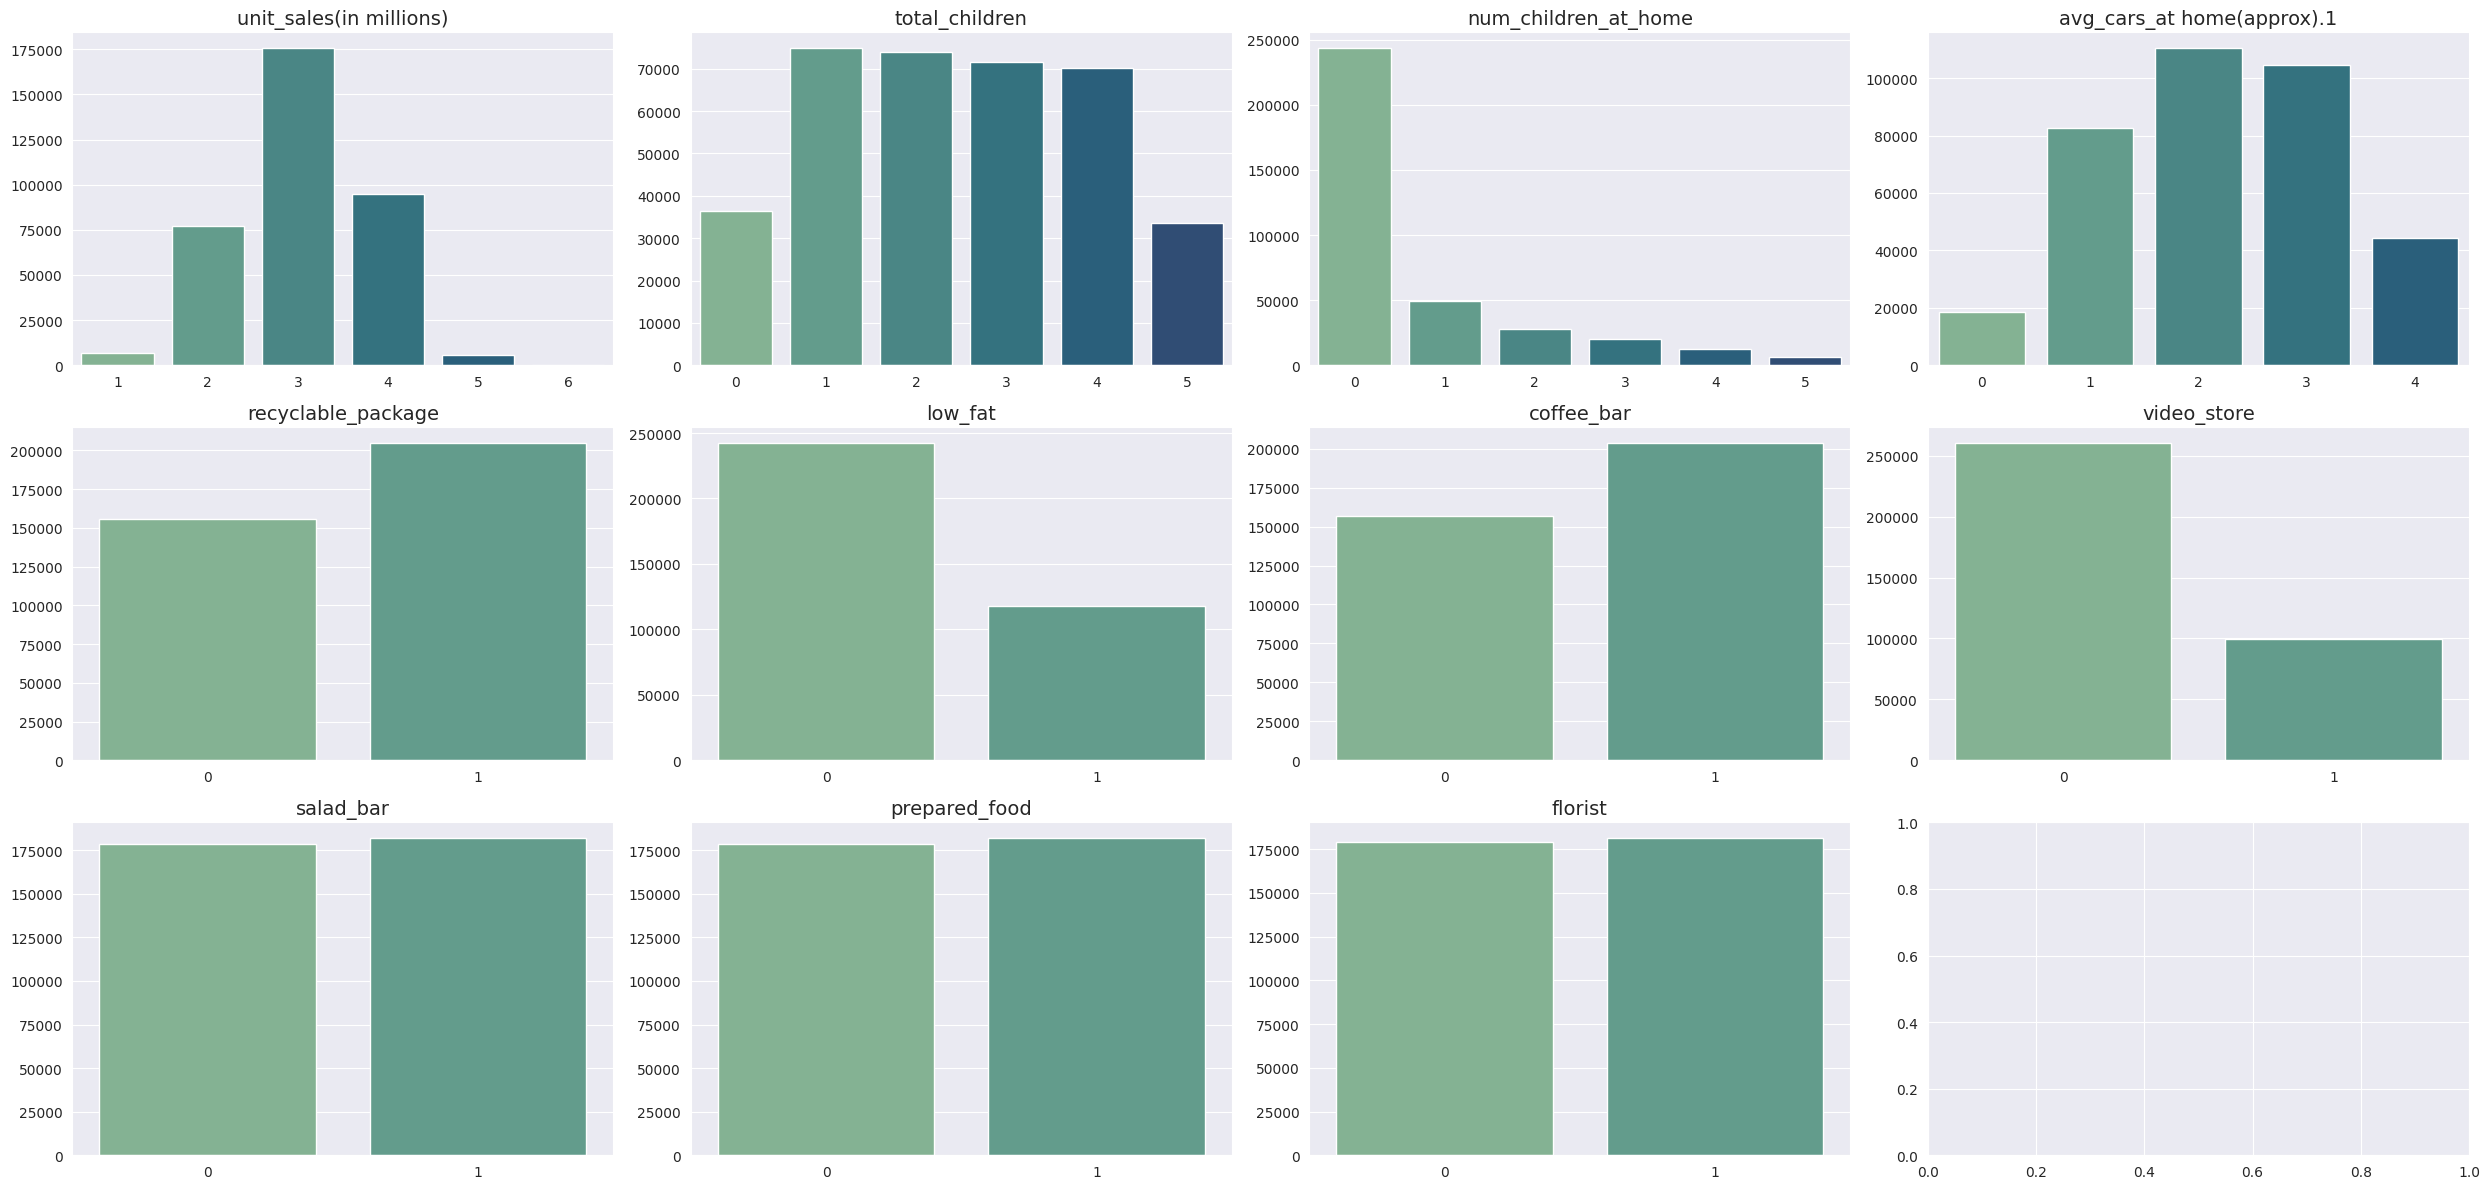

In [171]:
fig, axs = plt.subplots(3,4, figsize=(25,12))
axs = axs.ravel()

for i, col in enumerate(cat):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label=col, fontsize=14)

plt.tight_layout()

All category features have been distributed

## Bivariate

### Scatter Plot

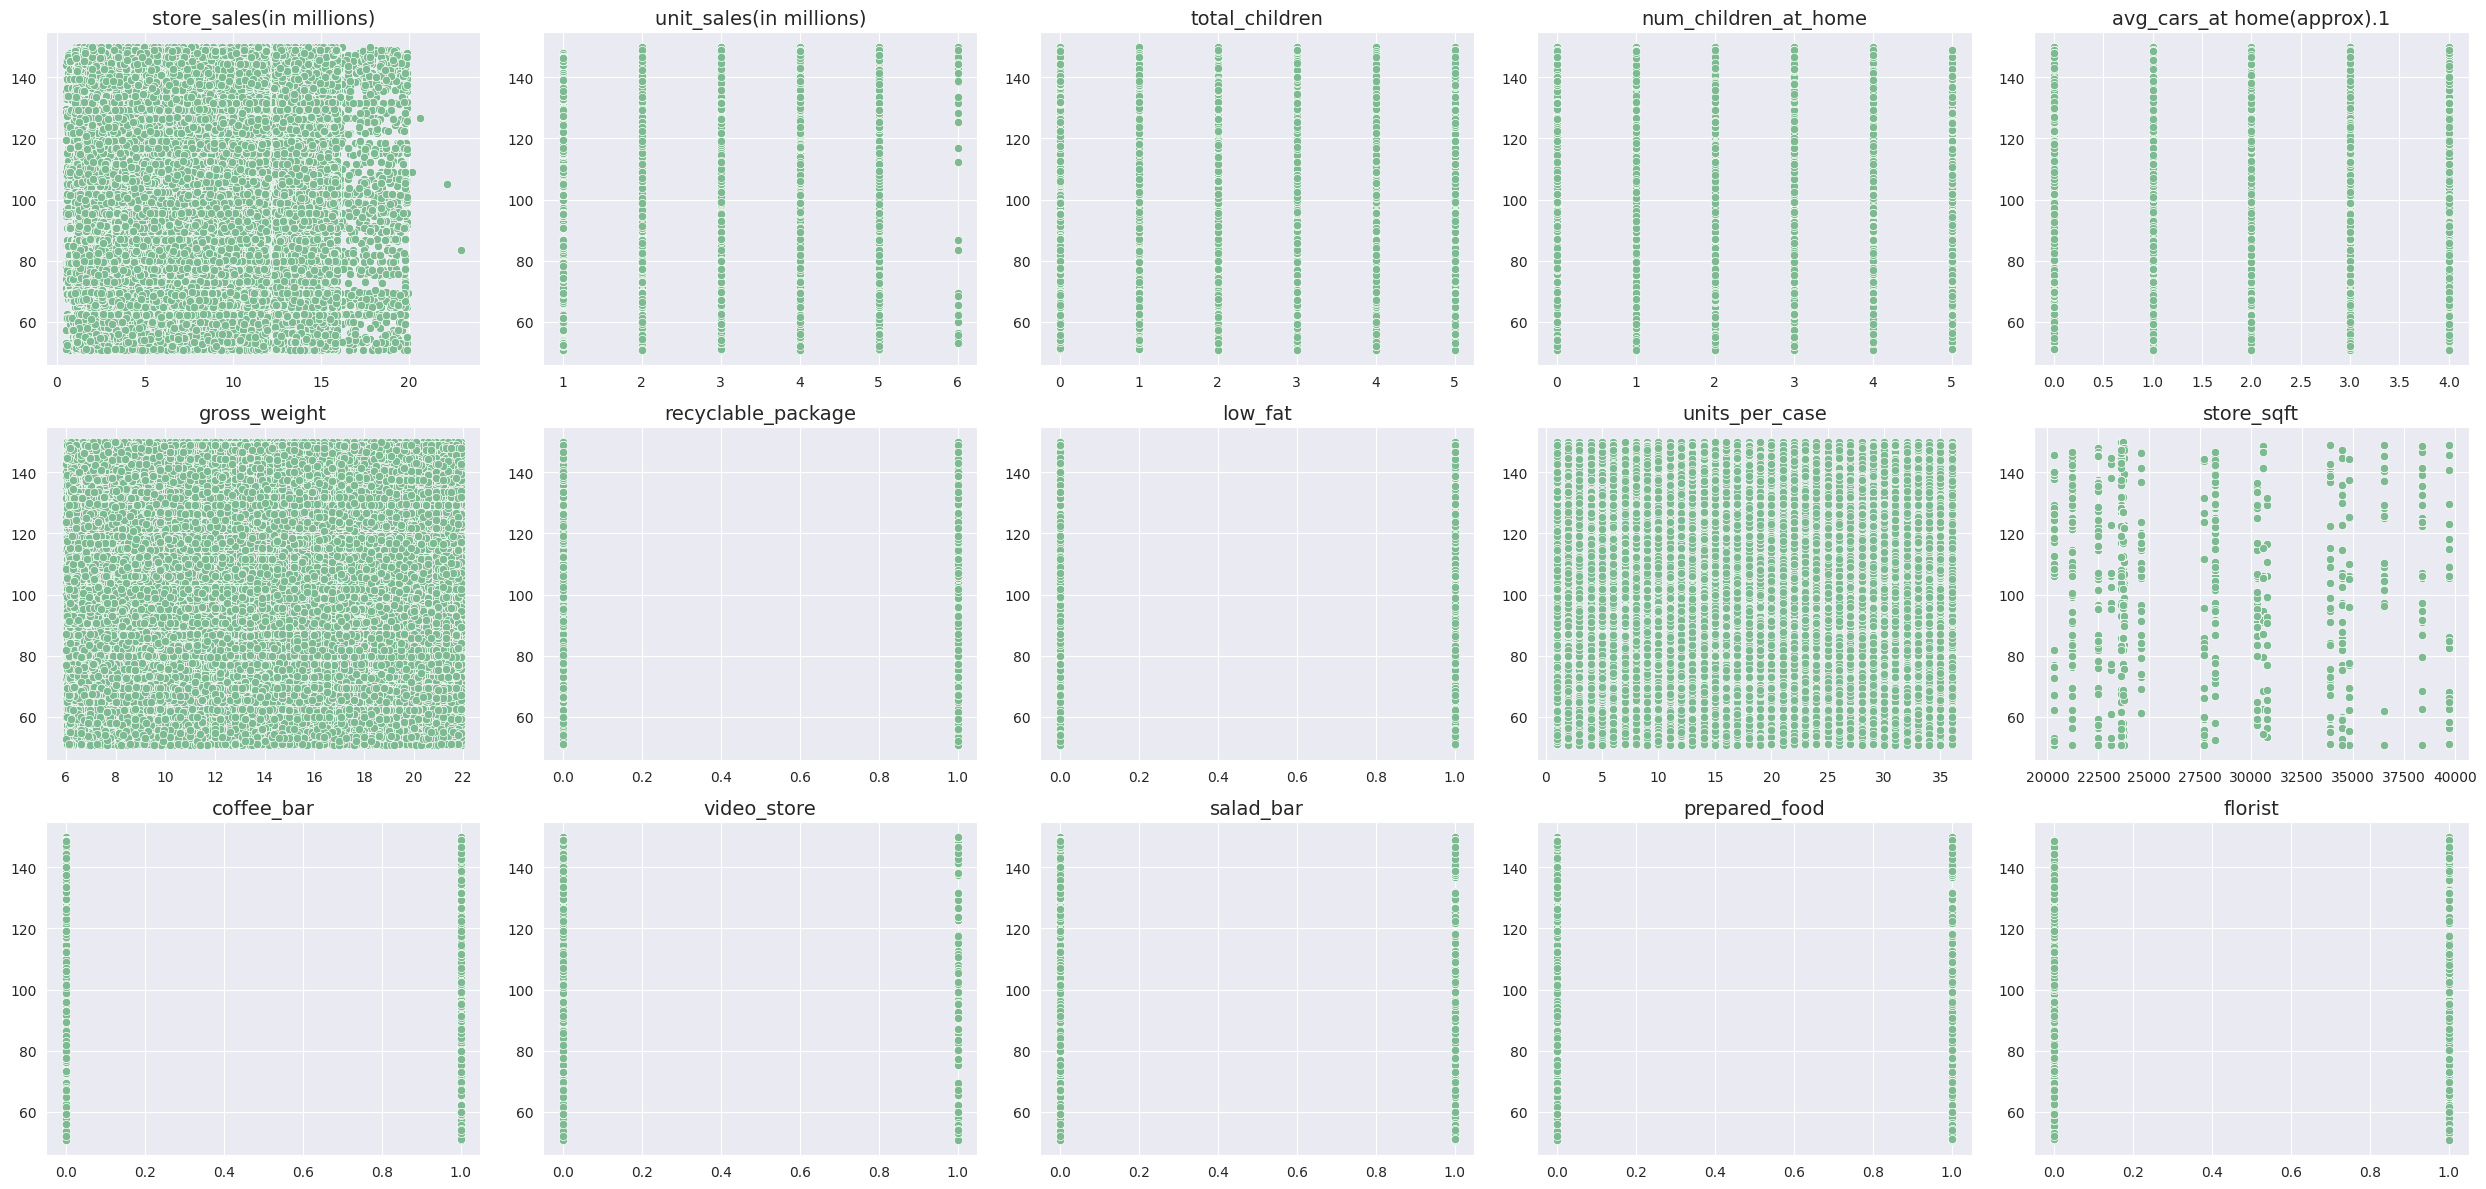

In [172]:
fig, axs = plt.subplots(3,5, figsize=(25,12))
axs = axs.ravel()

for i, col in enumerate(df.drop('cost', axis=1).columns):
    sns.scatterplot(data=df, x=col, y='cost', ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label=col, fontsize=14)

plt.tight_layout()

Not have visual correlation

### Distribution for Categorical Features

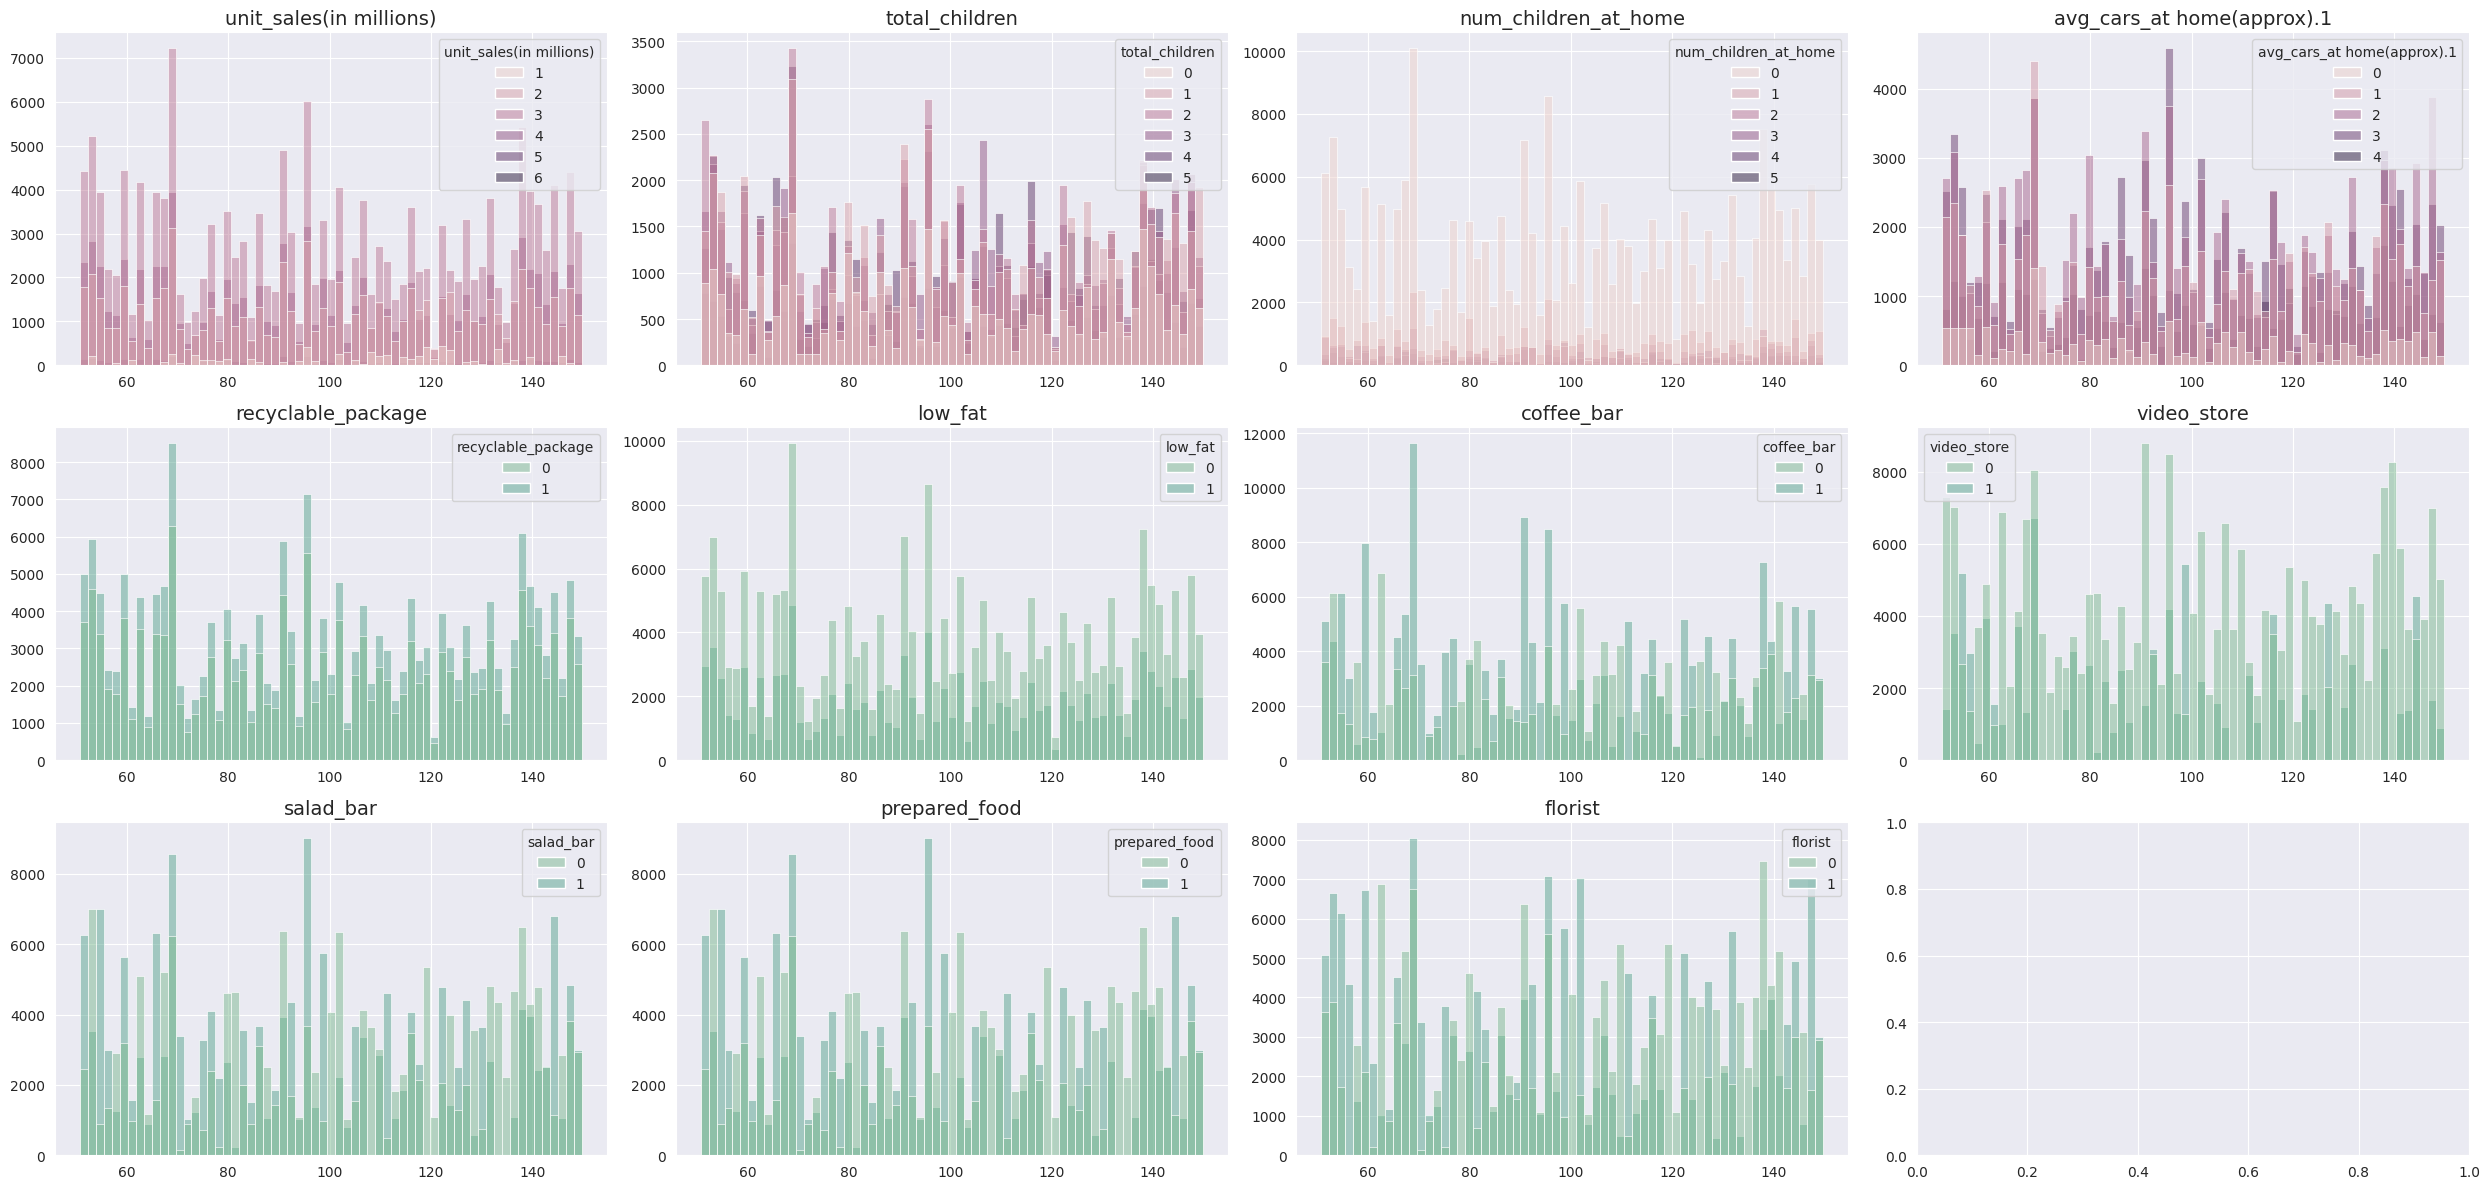

In [173]:
fig, axs = plt.subplots(3,4, figsize=(25,12))
axs = axs.ravel()

for i, col in enumerate(cat):
    sns.histplot(data=df, x='cost', hue=col, ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label=col, fontsize=14)

plt.tight_layout()

### Correlation

### All Features

<Axes: >

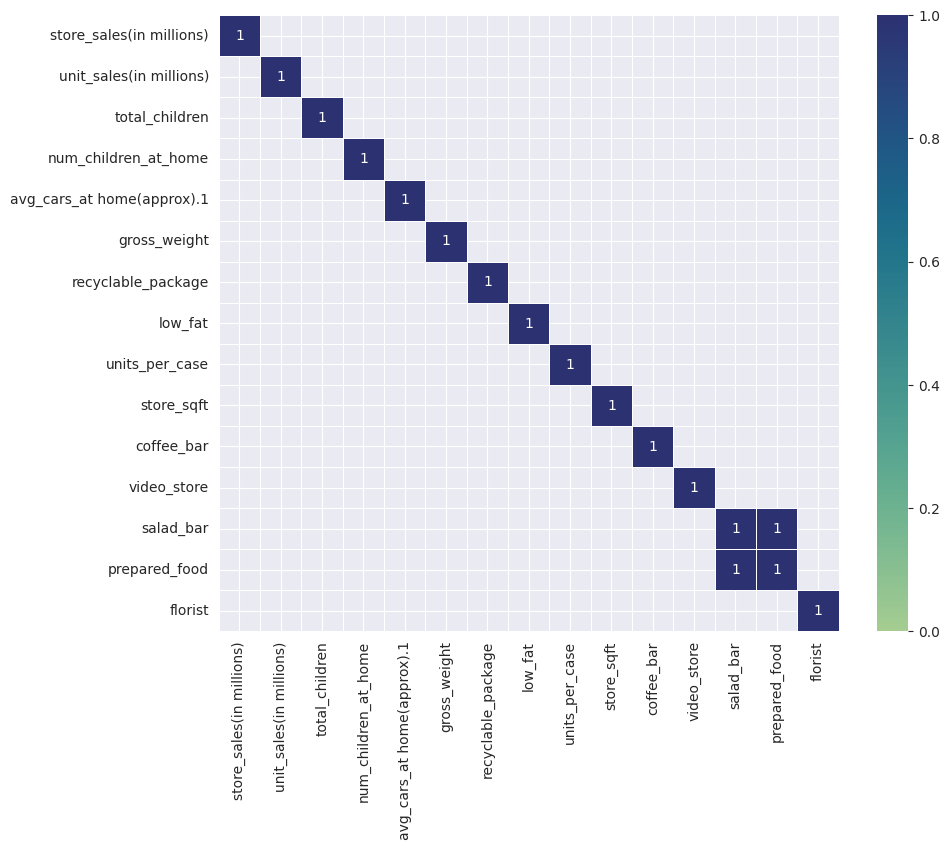

In [174]:
plt.figure(figsize=(10,8))
correlation = df.drop('cost', axis=1).corr()
sns.heatmap(correlation, mask = correlation < 0.8, linewidth=0.5, cmap='crest', annot=True, vmin=0)

`prepared_food` has high correlated with `salad_bar` 

### Target

<Axes: >

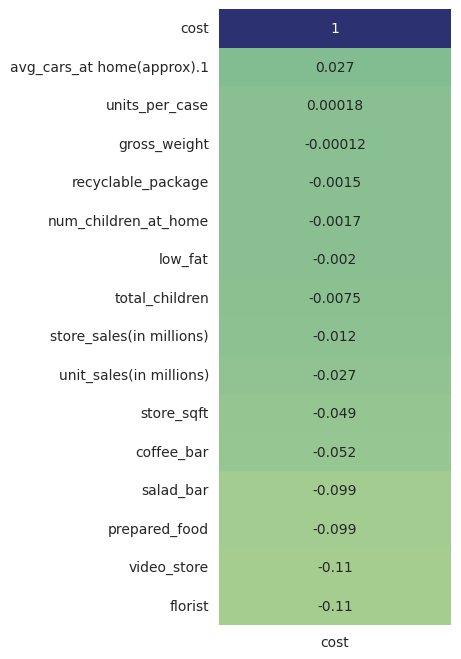

In [175]:
correlation = df.corr()
target_correlation = correlation[['cost']].sort_values(by='cost', ascending=False)

plt.figure(figsize=(3,8))
sns.heatmap(target_correlation, annot=True, cmap='crest', cbar=False)

Only `avg_cars_at home(approx).1` and `units_per_case` has positive correlation

# Data Processing
Now that we have finished analyzing our data and gaining insights through the various analyses and visualizations, we will need to leverage these insights to guide our pre-processing decision to provide clean, error-free data for our model to be trained on later.

## Multicollinearity
From the correlation matrix above, we have identified certain features that are highly correlated We will eliminate the highly correlated features to avoid the multicollinearity problem explained earlier (redundancy)

In [176]:
df = df.drop('prepared_food', axis=1)

## Dealing with Outliers
Removing outliers will prevent the performance of our models from being affected by extreme values. We will eliminate outliers based on a given threshold value. 

From our boxplot earlier, we identified the following features with extreme outliers:

<Axes: xlabel='store_sales(in millions)'>

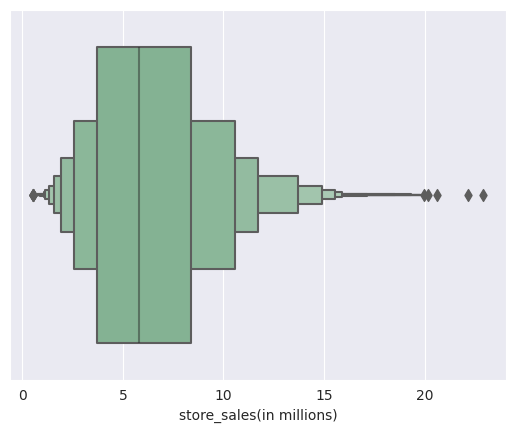

In [177]:
sns.boxenplot(data=df, x=outlier_col)

In [178]:
df.loc[ df[outlier_col] > 20, outlier_col ]

40241     20.14
59110     22.92
86680     20.60
183576    22.16
Name: store_sales(in millions), dtype: float64

<Axes: xlabel='store_sales(in millions)'>

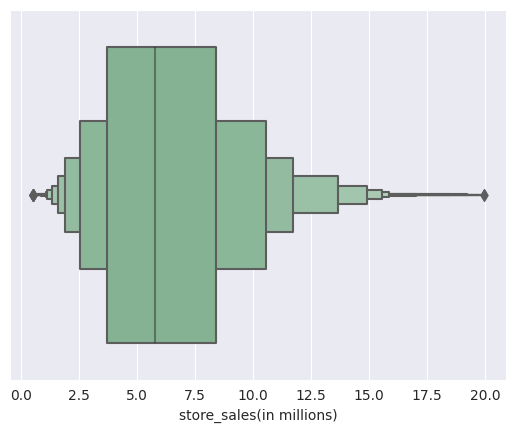

In [179]:
df = df[ df[outlier_col] < 20 ]
sns.boxenplot(data=df, x=outlier_col)

## Positive Correlated Features
Only `avg_cars_at home(approx).1` and `units_per_case` has positive correlation

In [180]:
p_corr = ['avg_cars_at home(approx).1', 'units_per_case']

# Modeling

In [181]:
#df.to_csv('model_train') # for jupyter notebook testing

In [182]:
X = df.drop('cost', axis=1)
y = df['cost']

In [183]:
# Positive Correlated Testing
X_p = df[p_corr]

# Comparing Performance

In [184]:
algorithms = {
    'Linear Regression': LinearRegression(),
    'Bayesian Ridge': BayesianRidge(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'ARD Regression': ARDRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    #'K-Nearest Neighbors': KNeighborsRegressor()
    #'Gradient Boosting': GradientBoostingRegressor(),
    #'Random Forest': RandomForestRegressor(),
    #'Extra Trees': ExtraTreesRegressor(),
    #'Support Vector Regression': SVR(),
    #'Multi-Layer Perceptron': MLPRegressor()
}

In [185]:
preprocessors = {
    'Standard':  make_column_transformer((StandardScaler(), num)),
    #'MinMax': make_column_transformer((MinMaxScaler(), num)),
    #'Robust': make_column_transformer((RobustScaler(), num))
}

In [186]:
preprocessors_p = {
    'Standard':  make_column_transformer((StandardScaler(), p_corr)),
    #'MinMax': make_column_transformer((MinMaxScaler(), p_corr)),
    #'Robust': make_column_transformer((RobustScaler(), p_corr))
}

In [187]:
#RMLSE
scoring = make_scorer(mean_squared_log_error, squared=False)

In [188]:
def test_algorithms(X,y, preprocessors):
    result = pd.DataFrame()
    cv = RepeatedKFold(n_splits=5, n_repeats=3)
    total_time = 0
    for key, algorithm in algorithms.items():
        for keyp, preprocessor in preprocessors.items():
            
            start_time = time.time()
            print(f'| {time.ctime(start_time)} | {keyp}, {key}...', end = '')
            
            model = make_pipeline(preprocessor, algorithm)
            cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator =True)
            
            new_row = {
                'Algorithm': key,
                'Preprocessor': keyp,
                'test_score': round(cv_results["test_score"].mean(), 5),
                'train_score': round(cv_results["train_score"].mean(), 5),
                'fit_time': round(cv_results["fit_time"].mean(), 5),
                'score_time': round(cv_results["score_time"].mean(), 5),
                'run_time': round((time.time() - start_time) / 60, 5),
                'model': cv_results['estimator'][0]
            }

            total_time += new_row["run_time"]
            result = pd.concat([result, pd.Series(new_row)], axis=1)
            print(f'finished!!! {new_row["run_time"]} min(s) | Score:{new_row["test_score"]} | Total Time: {round(total_time, 2)} min(s) |')
    
    return result.transpose().sort_values(by='test_score', ascending=False)

In [189]:
result_p = test_algorithms(X_p, y, preprocessors_p)

| Mon Apr  3 16:56:36 2023 | Standard, Linear Regression...finished!!! 0.03199 min(s) | Score:0.32018 | Total Time: 0.03 min(s) |
| Mon Apr  3 16:56:38 2023 | Standard, Bayesian Ridge...finished!!! 0.03546 min(s) | Score:0.32018 | Total Time: 0.07 min(s) |
| Mon Apr  3 16:56:40 2023 | Standard, Ridge Regression...finished!!! 0.02352 min(s) | Score:0.32018 | Total Time: 0.09 min(s) |
| Mon Apr  3 16:56:41 2023 | Standard, Lasso Regression...finished!!! 0.03305 min(s) | Score:0.32031 | Total Time: 0.12 min(s) |
| Mon Apr  3 16:56:43 2023 | Standard, Elastic Net...finished!!! 0.04644 min(s) | Score:0.32026 | Total Time: 0.17 min(s) |
| Mon Apr  3 16:56:46 2023 | Standard, ARD Regression...finished!!! 0.05947 min(s) | Score:0.32018 | Total Time: 0.23 min(s) |
| Mon Apr  3 16:56:50 2023 | Standard, Decision Tree...finished!!! 0.05491 min(s) | Score:0.32015 | Total Time: 0.28 min(s) |
| Mon Apr  3 16:56:53 2023 | Standard, LightGBM...finished!!! 0.85183 min(s) | Score:0.32014 | Total Time: 1

In [190]:
result_p.set_index(['Preprocessor', 'Algorithm']).sort_values(by='test_score')

test_score train_score fit_time score_time  \
Preprocessor Algorithm                                                      
Standard     AdaBoost             0.32011     0.32009  1.22376    0.03427   
             LightGBM             0.32014     0.31997  1.81312    0.30794   
             XGBoost              0.32014     0.31997  10.5716    0.15786   
             Decision Tree        0.32015     0.31997   0.1539    0.01385   
             Linear Regression    0.32018     0.32018  0.07383    0.01139   
             Bayesian Ridge       0.32018     0.32018  0.06984     0.0136   
             Ridge Regression     0.32018     0.32018  0.04078    0.01139   
             ARD Regression       0.32018     0.32018  0.12651    0.02343   
             Elastic Net          0.32026     0.32026  0.07691    0.02399   
             Lasso Regression     0.32031     0.32031  0.05992    0.01397   

                               run_time  \
Preprocessor Algorithm                    
Standard     AdaBoost           0.34763   
             LightGBM           0.85183   
             XGBoost            2.83753   
             Decision Tree      0.05491   
             Linear Regression  0.03199   
             Bayesian Ridge     0.03546   
             Ridge Regression   0.02352   
             ARD Regression     0.05947   
             Elastic Net        0.04644   
             Lasso Regression   0.03305   

                                                                            model  
Preprocessor Algorithm                                                             
Standard     AdaBoost           (ColumnTransformer(transformers=[('standardsca...  
             LightGBM           (ColumnTransformer(transformers=[('standardsca...  
             XGBoost            (ColumnTransformer(transformers=[('standardsca...  
             Decision Tree      (ColumnTransformer(transformers=[('standardsca...  
             Linear Regression  (ColumnTransformer(transformers=[('standardsca...  
             Bayesian Ridge     (ColumnTransformer(transformers=[('standardsca...  
             Ridge Regression   (ColumnTransformer(transformers=[('standardsca...  
             ARD Regression     (ColumnTransformer(transformers=[('standardsca...  
             Elastic Net        (ColumnTransformer(transformers=[('standardsca...  
             Lasso Regression   (ColumnTransformer(transformers=[('standardsca...

In [191]:
result = test_algorithms(X, y, preprocessors)

| Mon Apr  3 17:00:55 2023 | Standard, Linear Regression...finished!!! 0.04303 min(s) | Score:0.31995 | Total Time: 0.04 min(s) |
| Mon Apr  3 17:00:58 2023 | Standard, Bayesian Ridge...finished!!! 0.04665 min(s) | Score:0.31995 | Total Time: 0.09 min(s) |
| Mon Apr  3 17:01:01 2023 | Standard, Ridge Regression...finished!!! 0.03408 min(s) | Score:0.31995 | Total Time: 0.12 min(s) |
| Mon Apr  3 17:01:03 2023 | Standard, Lasso Regression...finished!!! 0.05874 min(s) | Score:0.32013 | Total Time: 0.18 min(s) |
| Mon Apr  3 17:01:06 2023 | Standard, Elastic Net...finished!!! 0.05069 min(s) | Score:0.32008 | Total Time: 0.23 min(s) |
| Mon Apr  3 17:01:09 2023 | Standard, ARD Regression...finished!!! 0.04264 min(s) | Score:0.31995 | Total Time: 0.28 min(s) |
| Mon Apr  3 17:01:12 2023 | Standard, Decision Tree...finished!!! 0.43124 min(s) | Score:0.35616 | Total Time: 0.71 min(s) |
| Mon Apr  3 17:01:38 2023 | Standard, LightGBM...finished!!! 0.6613 min(s) | Score:0.31074 | Total Time: 1.

In [192]:
result.set_index(['Preprocessor', 'Algorithm']).sort_values(by='test_score')

test_score train_score  fit_time score_time  \
Preprocessor Algorithm                                                       
Standard     LightGBM             0.31074     0.30952   1.58667    0.21076   
             XGBoost              0.31148     0.30695  16.14264    0.17673   
             AdaBoost             0.31412      0.3141   2.61687    0.04646   
             Linear Regression    0.31995     0.31994   0.11092    0.01276   
             Bayesian Ridge       0.31995     0.31994   0.10806    0.01881   
             Ridge Regression     0.31995     0.31994   0.07355    0.01303   
             ARD Regression       0.31995     0.31995   0.11021    0.01297   
             Elastic Net          0.32008     0.32008   0.09898    0.02052   
             Lasso Regression     0.32013     0.32013   0.10393    0.03029   
             Decision Tree        0.35616      0.2639   1.47077    0.05225   

                               run_time  \
Preprocessor Algorithm                    
Standard     LightGBM            0.6613   
             XGBoost            4.25217   
             AdaBoost           0.71009   
             Linear Regression  0.04303   
             Bayesian Ridge     0.04665   
             Ridge Regression   0.03408   
             ARD Regression     0.04264   
             Elastic Net        0.05069   
             Lasso Regression   0.05874   
             Decision Tree      0.43124   

                                                                            model  
Preprocessor Algorithm                                                             
Standard     LightGBM           (ColumnTransformer(transformers=[('standardsca...  
             XGBoost            (ColumnTransformer(transformers=[('standardsca...  
             AdaBoost           (ColumnTransformer(transformers=[('standardsca...  
             Linear Regression  (ColumnTransformer(transformers=[('standardsca...  
             Bayesian Ridge     (ColumnTransformer(transformers=[('standardsca...  
             Ridge Regression   (ColumnTransformer(transformers=[('standardsca...  
             ARD Regression     (ColumnTransformer(transformers=[('standardsca...  
             Elastic Net        (ColumnTransformer(transformers=[('standardsca...  
             Lasso Regression   (ColumnTransformer(transformers=[('standardsca...  
             Decision Tree      (ColumnTransformer(transformers=[('standardsca...

# Hyper Parameterrs	

In [ ]:
def hyper_parameter_tunning(X, y, model, params):
  start_time = time.time()
  # Define the metric to be used
  scoring = {'rmlse': 'neg_root_mean_squared_error'}

  # Define the cross-validator object
  cv = RepeatedKFold(n_splits=5, n_repeats=3)

  # Perform RandomSearchCV
  rs = RandomizedSearchCV(model, param_distributions=params,
                          n_iter=10, scoring=scoring, refit='rmlse', cv=cv)
  
  # Fit the RandomSearchCV object
  rs.fit(X, y)

  # Perform Cross-Validation for the model with the best hyperparameters found by RandomSearchCV
  cv_results = cross_validate(rs.best_estimator_, X, y, scoring=scoring, cv=cv)
  
  end_time = round((time.time() - start_time) / 60, 2)
  print(f'finished!!! {end_time} min(s)')

  # Print the mean of the RMLSE metric on the test data
  print(f"RMLSE: {-cv_results['test_rmlse'].mean():.4f}")

  # Print the best hyperparameters found
  print(f"Best hyperparameters: {rs.best_params_}")

  # Print the best trained model
  print("Best trained model: ", rs.best_estimator_)
  return  rs.best_estimator_

## Positive correlation

### AdaBoost

In [193]:
model_adaboost_p = result_p.set_index('Algorithm').loc['AdaBoost']['model']
model_adaboost_p

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['avg_cars_at home(approx).1',
                                                   'units_per_case'])])),
                ('adaboostregressor', AdaBoostRegressor())])

In [194]:
adaboost_params = {'adaboostregressor__n_estimators': [50, 100, 200],
              'adaboostregressor__learning_rate': [0.1, 0.5, 1.0],
              'adaboostregressor__loss': ['linear', 'square', 'exponential']}

In [196]:
best_adaboost_p = hyper_parameter_tunning(X_p, y, model_adaboost_p, adaboost_params)

finished!!! 29.64 min(s)
RMLSE: 29.9176
Best hyperparameters: {'adaboostregressor__n_estimators': 200, 'adaboostregressor__loss': 'linear', 'adaboostregressor__learning_rate': 0.1}
Best trained model:  Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['avg_cars_at home(approx).1',
                                                   'units_per_case'])])),
                ('adaboostregressor',
                 AdaBoostRegressor(learning_rate=0.1, n_estimators=200))])


## LGBM

In [ ]:
lgbm_params = {'lgbmregressor__n_estimators': [50, 100, 200],
              'lgbmregressor__max_depth': [5, 10, 20],
              'lgbmregressor__learning_rate': [0.05, 0.1, 0.2],
              'lgbmregressor__num_leaves': [30, 50, 100]}

In [208]:
model_lgbm_p = result_p.set_index('Algorithm').loc['LightGBM']['model']
model_lgbm_p

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['avg_cars_at home(approx).1',
                                                   'units_per_case'])])),
                ('lgbmregressor', LGBMRegressor())])

In [209]:
best_lgbm_p = hyper_parameter_tunning(X, y, model_lgbm_p, lgbm_params)

finished!!! 7.13 min(s)
RMLSE: 29.9213
Best hyperparameters: {'lgbmregressor__num_leaves': 30, 'lgbmregressor__n_estimators': 50, 'lgbmregressor__max_depth': 10, 'lgbmregressor__learning_rate': 0.05}
Best trained model:  Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['avg_cars_at home(approx).1',
                                                   'units_per_case'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.05, max_depth=10,
                               n_estimators=50, num_leaves=30))])


## All Features

### LGBM

In [200]:
model_lgbm = result.set_index('Algorithm').loc['LightGBM']['model']
model_lgbm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['store_sales(in millions)', 'gross_weight', 'units_per_case',
       'store_sqft'],
      dtype='object'))])),
                ('lgbmregressor', LGBMRegressor())])

In [202]:
best_lgbm = hyper_parameter_tunning(X, y, model_lgbm, lgbm_params)

finished!!! 5.61 min(s)
RMLSE: 29.0968
Best hyperparameters: {'lgbmregressor__num_leaves': 50, 'lgbmregressor__n_estimators': 50, 'lgbmregressor__max_depth': 5, 'lgbmregressor__learning_rate': 0.1}
Best trained model:  Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['store_sales(in millions)', 'gross_weight', 'units_per_case',
       'store_sqft'],
      dtype='object'))])),
                ('lgbmregressor',
                 LGBMRegressor(max_depth=5, n_estimators=50, num_leaves=50))])


## AdaBoost

In [205]:
model_adaboost = result.set_index('Algorithm').loc['AdaBoost']['model']
model_adaboost

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['store_sales(in millions)', 'gross_weight', 'units_per_case',
       'store_sqft'],
      dtype='object'))])),
                ('adaboostregressor', AdaBoostRegressor())])

In [206]:
best_adaboost = hyper_parameter_tunning(X, y, model_adaboost, adaboost_params)

finished!!! 42.56 min(s)
RMLSE: 29.3798
Best hyperparameters: {'adaboostregressor__n_estimators': 100, 'adaboostregressor__loss': 'exponential', 'adaboostregressor__learning_rate': 0.1}
Best trained model:  Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['store_sales(in millions)', 'gross_weight', 'units_per_case',
       'store_sqft'],
      dtype='object'))])),
                ('adaboostregressor',
                 AdaBoostRegressor(learning_rate=0.1, loss='exponential',
                                   n_estimators=100))])


# Submission

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Playground Series S3 EP 11/Input/test.csv')

In [ ]:
test.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
test.shape

(240224, 16)

In [ ]:
X_test = test.drop(['id', 'prepared_food'], axis=1)
X_test_p = test[p_corr]

In [ ]:
def submit(name, final_model, X_test):
  pred = final_model.predict(X_test)
  sub = pd.Series(pred, index = test['id'], name='cost')
  
  path = f'/content/drive/MyDrive/Data Science/Projects/Playground Series S3 EP 11//Output/{name}_model.csv'
  sub.to_csv(path, header=True)
  return f'{name} Submitted!!!'

In [203]:
submit('AdaBoost_p', best_adaboost_p, X_test_p)

'AdaBoost_p Submitted!!!'

In [210]:
submit('LGBM_p', best_lgbm_p, X_test_p)

'LGBM_p Submitted!!!'

In [204]:
submit('LGBM', best_lgbm, X_test)

'LGBM Submitted!!!'

In [207]:
submit('AdaBoost', best_adaboost, X_test)

'AdaBoost Submitted!!!'